In [823]:
import pandas as pd

# Assuming `data` is already loaded and `date` column is converted to datetime as index
data = pd.read_csv('RELIANCE_15m.csv')

# Step 1: Convert 'date' column to datetime format and set as index
data['date'] = pd.to_datetime(data['date'])
#data.set_index('date', inplace=True)

# Step 2: Check for missing values
missing_values = data.isnull().sum()
print("Missing values per column:\n", missing_values)

# Option to drop or fill missing values
data.dropna(inplace=True)  # or use data.fillna(method='ffill') for forward fill

# Step 3: Sort by date to ensure chronological order
data.sort_index(inplace=True)

# Preview cleaned data
print(data.head())


Missing values per column:
 date      0
open      0
high      0
low       0
close     0
volume    0
dtype: int64
                       date    open    high     low   close  volume
0 2015-02-02 09:15:00+05:30  432.90  434.30  431.55  432.70  622129
1 2015-02-02 09:30:00+05:30  432.80  432.90  431.50  431.55  305896
2 2015-02-02 09:45:00+05:30  431.55  432.35  431.00  431.75  246096
3 2015-02-02 10:00:00+05:30  431.75  432.25  430.30  431.50  220553
4 2015-02-02 10:15:00+05:30  431.50  432.00  431.05  431.50   96235


In [824]:
def calculate_sharpe_ratio(returns, risk_free_rate=0.0):
    # Calculate daily returns
    excess_returns = returns - risk_free_rate
    # Calculate annualized Sharpe Ratio
    return np.sqrt(252) * (excess_returns.mean() / excess_returns.std())


In [825]:
import numpy as np
import pandas as pd
from sklearn.model_selection import ParameterGrid

# Assuming data is already prepared and has the necessary columns
# Define parameters for optimization
param_grid = {
    'short_window': [10, 20, 30],
    'long_window': [50, 100, 200]
}

best_sharpe = -np.inf
best_params = None

# Iterate through all combinations of parameters
for params in ParameterGrid(param_grid):
    short_window = params['short_window']
    long_window = params['long_window']
    
    # Define moving averages
    data['short_mavg'] = data['close'].rolling(window=short_window).mean()
    data['long_mavg'] = data['close'].rolling(window=long_window).mean()

    # Create signals
    data['signal'] = 0
    data['signal'][data['short_mavg'] > data['long_mavg']] = 1  # Buy signal
    data['signal'][data['short_mavg'] < data['long_mavg']] = -1  # Sell signal
    data['position'] = data['signal'].shift()  # Position based on previous signal

    # Calculate daily returns and strategy returns
    data['returns'] = data['close'].pct_change()
    data['strategy_returns'] = data['returns'] * data['position'].shift()

    # Calculate Sharpe Ratio for the current parameters
    current_sharpe = calculate_sharpe_ratio(data['strategy_returns'].dropna())

    # Update best parameters if current Sharpe Ratio is higher
    if current_sharpe > best_sharpe:
        best_sharpe = current_sharpe
        best_params = params

print(f"Best parameters: {best_params} with Sharpe Ratio: {best_sharpe:.2f}")


Best parameters: {'long_window': 50, 'short_window': 10} with Sharpe Ratio: 0.27


C:\Users\harsh\AppData\Local\Temp\ipykernel_16832\800719453.py:26: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data['signal'][data['short_mavg'] > data['long_mavg']] = 1  # Buy signal
C:\Users\harsh\AppData\Local\Temp\ipykernel_16832\80071

In [826]:
# Use the optimal parameters for backtesting
short_window = 10
long_window = 50

# Define moving averages
data['short_mavg'] = data['close'].rolling(window=short_window).mean()
data['long_mavg'] = data['close'].rolling(window=long_window).mean()

# Create signals
data['signal'] = 0
data['signal'][data['short_mavg'] > data['long_mavg']] = 1  # Buy signal
data['signal'][data['short_mavg'] < data['long_mavg']] = -1  # Sell signal
data['position'] = data['signal'].shift()  # Position based on previous signal

# Calculate daily returns and strategy returns
data['returns'] = data['close'].pct_change()
data['strategy_returns'] = data['returns'] * data['position'].shift()

# Drop NaN values that may have resulted from moving averages or shifts
data.dropna(inplace=True)


C:\Users\harsh\AppData\Local\Temp\ipykernel_16832\3483933635.py:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data['signal'][data['short_mavg'] > data['long_mavg']] = 1  # Buy signal
C:\Users\harsh\AppData\Local\Temp\ipykernel_16832\3483

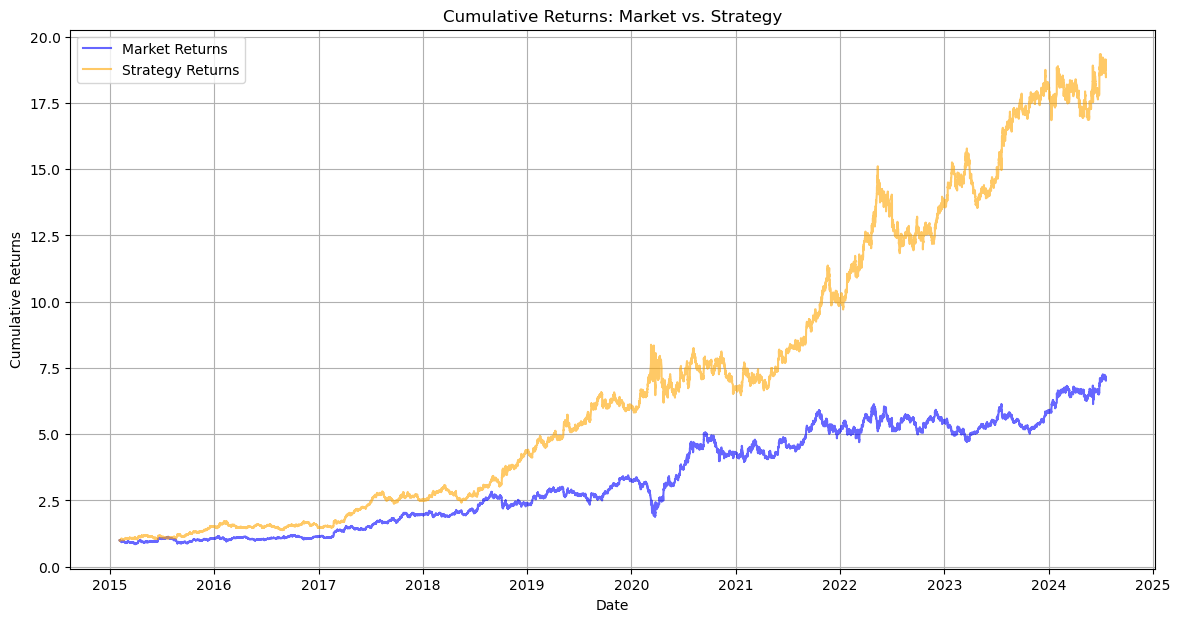

In [827]:
# Calculate cumulative returns
data['cumulative_market_returns'] = (1 + data['returns']).cumprod()
data['cumulative_strategy_returns'] = (1 + data['strategy_returns']).cumprod()
data['trend']=data['cumulative_strategy_returns']
# Visualize the results
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(data['date'], data['cumulative_market_returns'], label='Market Returns', color='blue', alpha=0.6)
plt.plot(data['date'], data['cumulative_strategy_returns'], label='Strategy Returns', color='orange', alpha=0.6)
plt.title('Cumulative Returns: Market vs. Strategy')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid()
plt.show()


In [828]:
# Calculate cumulative max to identify drawdowns
data['cumulative_max'] = data['cumulative_strategy_returns'].cummax()
data['drawdown'] = (data['cumulative_max'] - data['cumulative_strategy_returns']) / data['cumulative_max']

# Get the maximum drawdown as a single float
max_drawdown = data['drawdown'].max()


In [829]:
# Calculate performance metrics
sharpe_ratio = calculate_sharpe_ratio(data['strategy_returns'])
downside_returns = data[data['strategy_returns'] < 0]['strategy_returns']
sortino_ratio = np.sqrt(252) * (data['strategy_returns'].mean() / downside_returns.std())
max_drawdown = data['drawdown'].max()  # Fixed to ensure it's a float
annualized_return = (data['cumulative_strategy_returns'].iloc[-1] ** (252 / len(data)) - 1)
cumulative_return = data['cumulative_strategy_returns'].iloc[-1] - 1

# Print the performance metrics
print("Performance Metrics:")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Sortino Ratio: {sortino_ratio:.2f}")
print(f"Max Drawdown: {max_drawdown:.2%}")  # This should work now
print(f"Annualized Return: {annualized_return:.2%}")
print(f"Cumulative Return: {cumulative_return:.2%}")


Performance Metrics:
Sharpe Ratio: 0.27
Sortino Ratio: 0.35
Max Drawdown: 26.10%
Annualized Return: 1.27%
Cumulative Return: 1754.31%


In [830]:
# Entry and Exit signals
data['entry'] = 0
data['exit'] = 0

# Loop through the data to identify entry and exit points
for i in range(1, len(data)):
    if data['short_mavg'].iloc[i] > data['long_mavg'].iloc[i] and data['short_mavg'].iloc[i - 1] <= data['long_mavg'].iloc[i - 1]:
        data['entry'].iloc[i] = 1  # Buy signal
    elif data['short_mavg'].iloc[i] < data['long_mavg'].iloc[i] and data['short_mavg'].iloc[i - 1] >= data['long_mavg'].iloc[i - 1]:
        data['exit'].iloc[i] = 1  # Sell signal

# Position sizing based on fixed fractional method
risk_percentage = 0.02  # Risk 2% of capital
capital = 10000  # Example capital
atr = data['close'].rolling(window=14).apply(lambda x: np.max(x) - np.min(x), raw=False)  # ATR Calculation

data['position_size'] = (capital * risk_percentage) / (data['close'] * atr)

# Implement stop-loss and take-profit (example)
stop_loss_factor = 1.5  # ATR multiplier for stop-loss
take_profit_factor = 3  # Risk-reward ratio

data['stop_loss'] = data['close'] - (stop_loss_factor * atr)
data['take_profit'] = data['close'] + (take_profit_factor * (data['close'] - data['stop_loss']))


C:\Users\harsh\AppData\Local\Temp\ipykernel_16832\2085944306.py:10: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data['exit'].iloc[i] = 1  # Sell signal
C:\Users\harsh\AppData\Local\Temp\ipykernel_16832\2085944306.py:10: SettingWithCopyWarn

In [831]:
data.columns

Index(['date', 'open', 'high', 'low', 'close', 'volume', 'short_mavg',
       'long_mavg', 'signal', 'position', 'returns', 'strategy_returns',
       'cumulative_market_returns', 'cumulative_strategy_returns', 'trend',
       'cumulative_max', 'drawdown', 'entry', 'exit', 'position_size',
       'stop_loss', 'take_profit'],
      dtype='object')

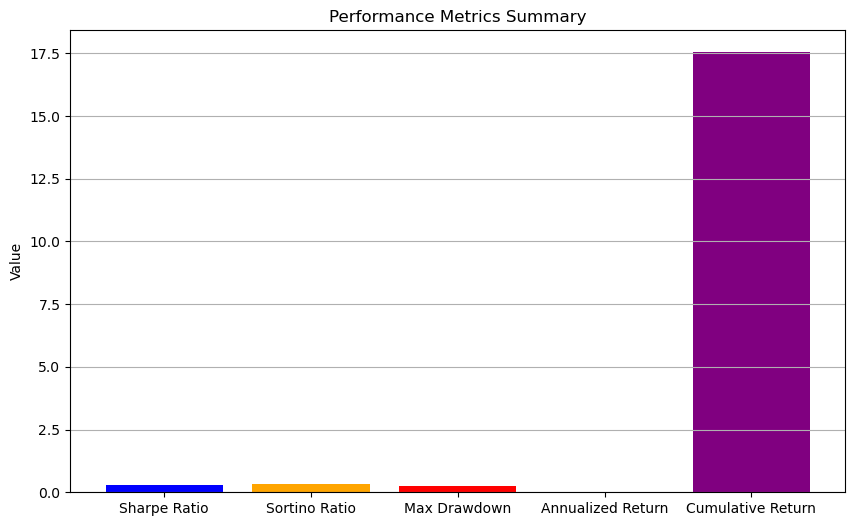

In [832]:
# Performance Metrics Summary
trend_performance_metrics = {
    'Sharpe Ratio': sharpe_ratio,
    'Sortino Ratio': sortino_ratio,
    'Max Drawdown': max_drawdown,
    'Annualized Return': annualized_return,
    'Cumulative Return': cumulative_return
}

# Bar Plot for Performance Metrics
plt.figure(figsize=(10, 6))
plt.bar(performance_metrics.keys(), trend_performance_metrics.values(), color=['blue', 'orange', 'red', 'green', 'purple'])
plt.title('Performance Metrics Summary')
plt.ylabel('Value')
plt.grid(axis='y')
plt.show()


In [833]:
#strategy 2

In [834]:
# Calculate the rate of change
lookback_period = 2  # You can adjust this period
data['momentum'] = data['close'].pct_change(periods=lookback_period)  # Rate of change


In [835]:
# Define entry and exit thresholds
entry_threshold = 0.03  # Buy when the momentum is greater than this
exit_threshold = 0.0001     # Exit when the momentum is less than this

# Initialize signals
data['position'] = 0  # 1 for long, 0 for no position
data['strategy_returns'] = 0.0


In [836]:
# Simulate trades
for i in range(1, len(data)):
    # Entry signal
    if data['momentum'].iloc[i] > entry_threshold:
        data['position'].iloc[i] = 1  # Long position
    elif data['momentum'].iloc[i] < exit_threshold:
        data['position'].iloc[i] = 0  # Exit position

    # Carry forward the previous position
    data['position'].iloc[i] = data['position'].iloc[i - 1] if data['position'].iloc[i] == 0 else data['position'].iloc[i]


C:\Users\harsh\AppData\Local\Temp\ipykernel_16832\2998435009.py:10: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data['position'].iloc[i] = data['position'].iloc[i - 1] if data['position'].iloc[i] == 0 else data['position'].iloc[i]
C:\Users

In [837]:
# Calculate daily returns
data['market_returns'] = data['close'].pct_change()
data['strategy_returns'] = data['position'].shift(1) * data['market_returns']  # Shift position for daily returns

# Incorporate transaction costs
transaction_costs = 0.001  # Example transaction cost (0.1%)
data['strategy_returns'] -= transaction_costs * np.abs(data['position'].diff())  # Adjust for costs


In [838]:
# Calculate performance metrics
sharpe_ratio = np.sqrt(252) * (data['strategy_returns'].mean() / data['strategy_returns'].std())
downside_returns = data[data['strategy_returns'] < 0]['strategy_returns']
sortino_ratio = np.sqrt(252) * (data['strategy_returns'].mean() / downside_returns.std()) if not downside_returns.empty else 0
cumulative_returns = (1 + data['strategy_returns']).cumprod() - 1
annualized_return = (1 + cumulative_returns.iloc[-1]) ** (252 / len(data)) - 1
data['moment']=(1 + data['strategy_returns']).cumprod() - 1

# Calculate max drawdown
data['cumulative_max'] = cumulative_returns.cummax()
data['drawdown'] = (data['cumulative_max'] - cumulative_returns) / data['cumulative_max']
max_drawdown = data['drawdown'].max()

# Print performance metr


In [839]:
# Make sure strategy returns are valid
data['strategy_returns'] = data['strategy_returns'].fillna(0)  # Fill NaN with 0
data['cumulative_returns'] = (1 + data['strategy_returns']).cumprod() - 1

# Calculate cumulative max only if cumulative returns exist
data['cumulative_max'] = data['cumulative_returns'].cummax()


In [840]:
# Calculate drawdown with safety checks
data['drawdown'] = (data['cumulative_max'] - data['cumulative_returns']) / data['cumulative_max'].replace(0, float('nan'))
max_drawdown = data['drawdown'].max()


In [841]:
#Print performance metrics
print("Performance Metrics:")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Sortino Ratio: {sortino_ratio:.2f}")
print(f"Max Drawdown: {max_drawdown:.2%}")
print(f"Annualized Return: {annualized_return:.2%}")
print(f"Cumulative Return: {cumulative_returns.iloc[-1]:.2%}")



Performance Metrics:
Sharpe Ratio: 0.20
Sortino Ratio: 0.24
Max Drawdown: 309.90%
Annualized Return: 0.84%
Cumulative Return: 592.58%


In [842]:
momentum_performance_metrics = {
    'Sharpe Ratio': sharpe_ratio,
    'Sortino Ratio': sortino_ratio,
    'Max Drawdown': max_drawdown,
    'Annualized Return': annualized_return,
    'Cumulative Return': cumulative_returns.iloc[-1]
}

In [843]:
#strategy3

In [844]:
import pandas as pd

# Load the data from the Excel file
#data = pd.read_excel('path_to_your_file.xlsx')  # Replace with your file path
#data['date'] = pd.to_datetime(data['date'])  # Convert date column to datetime
#data.set_index('date', inplace=True)  # Set the date as the index


In [845]:
# Calculate moving average and standard deviation
window = 20  # You can adjust this period
data['moving_average'] = data['close'].rolling(window=window).mean()
data['std_dev'] = data['close'].rolling(window=window).std()


In [846]:
# Calculate z-score
data['z_score'] = (data['close'] - data['moving_average']) / data['std_dev']

# Define entry and exit thresholds
entry_threshold = -2  # Buy when z-score is below this
exit_threshold = 0    # Exit when z-score crosses back to 0


In [847]:
# Initialize signals
data['position'] = 0  # 1 for long, 0 for no position
data['strategy_returns'] = 0.0

# Simulate trades
for i in range(1, len(data)):
    # Entry signals
    if data['z_score'].iloc[i] < entry_threshold:
        data['position'].iloc[i] = 1  # Long position
    elif data['z_score'].iloc[i] > exit_threshold:
        data['position'].iloc[i] = 0  # Exit position

    # Carry forward the previous position
    data['position'].iloc[i] = data['position'].iloc[i - 1] if data['position'].iloc[i] == 0 else data['position'].iloc[i]


C:\Users\harsh\AppData\Local\Temp\ipykernel_16832\3365332134.py:14: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data['position'].iloc[i] = data['position'].iloc[i - 1] if data['position'].iloc[i] == 0 else data['position'].iloc[i]
C:\Users

In [848]:
# Calculate daily returns
data['market_returns'] = data['close'].pct_change()
data['strategy_returns'] = data['position'].shift(1) * data['market_returns']  # Shift position for daily returns

# Incorporate transaction costs
transaction_costs = 0.001  # Example transaction cost (0.1%)
data['strategy_returns'] -= transaction_costs * np.abs(data['position'].diff())  # Adjust for costs


In [849]:
# Calculate performance metrics
data['strategy_returns'] = data['strategy_returns'].fillna(0)  # Fill NaN with 0
sharpe_ratio = np.sqrt(252) * (data['strategy_returns'].mean() / data['strategy_returns'].std())
downside_returns = data[data['strategy_returns'] < 0]['strategy_returns']
sortino_ratio = np.sqrt(252) * (data['strategy_returns'].mean() / downside_returns.std()) if not downside_returns.empty else 0
cumulative_returns = (1 + data['strategy_returns']).cumprod() - 1
annualized_return = (1 + cumulative_returns.iloc[-1]) ** (252 / len(data)) - 1
data['reverse']= (1 + data['strategy_returns']).cumprod() - 1

# Calculate max drawdown
data['cumulative_max'] = cumulative_returns.cummax()
data['drawdown'] = (data['cumulative_max'] - cumulative_returns) / (data['cumulative_max']+1)
max_drawdown = data['drawdown'].max()


# Print performance metrics
print("Performance Metrics:")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Sortino Ratio: {sortino_ratio:.2f}")
print(f"Max Drawdown: {max_drawdown:.2%}")
print(f"Annualized Return: {annualized_return:.2%}")
print(f"Cumulative Return: {cumulative_returns.iloc[-1]:.2%}")


Performance Metrics:
Sharpe Ratio: 0.19
Sortino Ratio: 0.25
Max Drawdown: 45.38%
Annualized Return: 0.85%
Cumulative Return: 611.49%


In [850]:
mean_performance_metrics = {
    'Sharpe Ratio': sharpe_ratio,
    'Sortino Ratio': sortino_ratio,
    'Max Drawdown': max_drawdown,
    'Annualized Return': annualized_return,
    'Cumulative Return': cumulative_returns.iloc[-1]
}

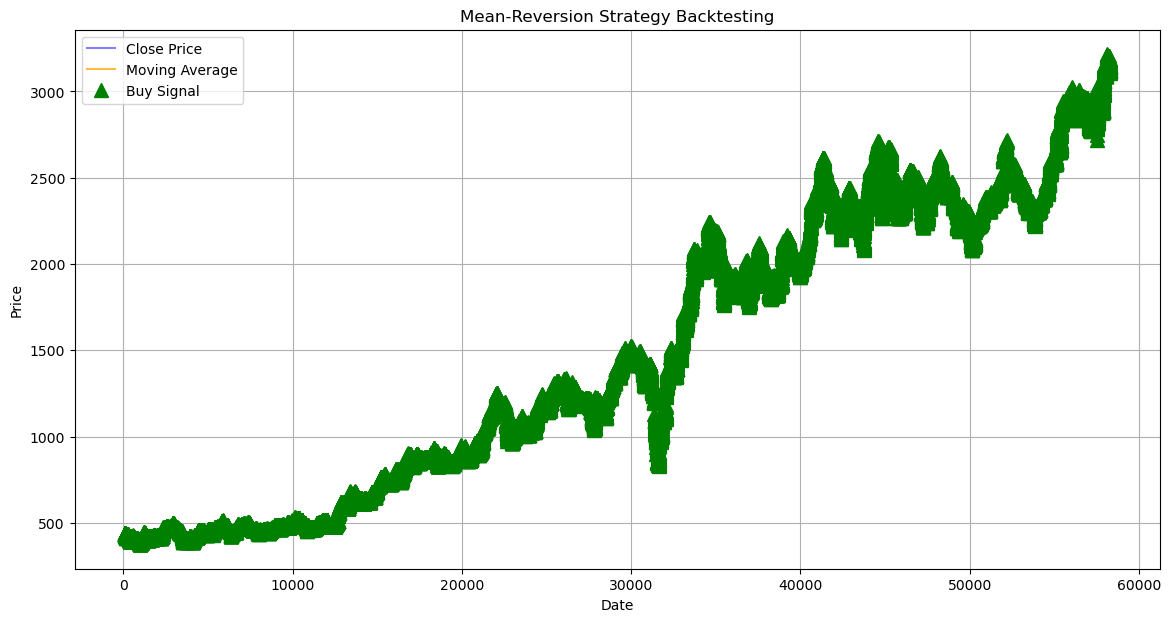

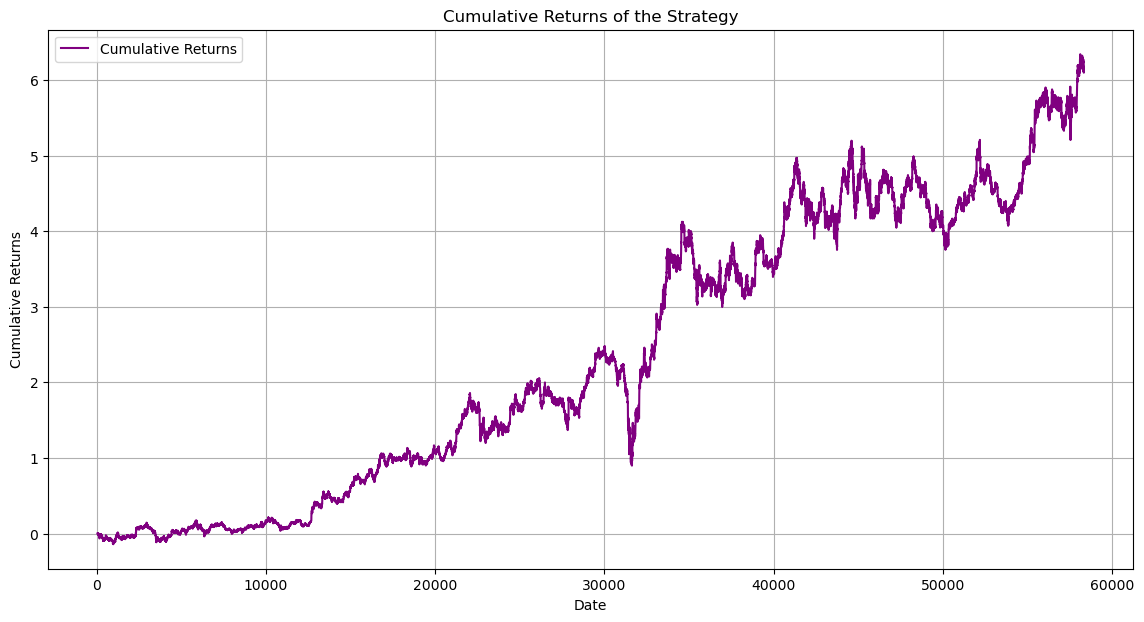

In [851]:
import matplotlib.pyplot as plt

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(data['close'], label='Close Price', color='blue', alpha=0.5)
plt.plot(data['moving_average'], label='Moving Average', color='orange', alpha=0.75)
plt.plot(data[data['position'] == 1].index, data['close'][data['position'] == 1], '^', markersize=10, color='g', label='Buy Signal')
plt.title('Mean-Reversion Strategy Backtesting')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

# Plot cumulative returns
plt.figure(figsize=(14, 7))
plt.plot(cumulative_returns, label='Cumulative Returns', color='purple')
plt.title('Cumulative Returns of the Strategy')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid()
plt.show()


In [895]:
# Define weights for each strategy
weights = {
    'trend_following': 0.45,
    'mean_reversion': 0.1,
    'momentum': 0.45,
}

# Assume you have returns for each strategy stored in respective variables
data['portfolio_returns'] = (weights['trend_following'] * data['trend'] +
                             weights['mean_reversion'] * data['reverse'] +
                             weights['momentum'] * data['momentum'])


In [897]:
data['portfolio_returns'].isnull().sum()
data['portfolio_returns'].fillna(0, inplace=True)


C:\Users\harsh\AppData\Local\Temp\ipykernel_16832\440119789.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['portfolio_returns'].fillna(0, inplace=True)


In [899]:
def calculate_portfolio_metrics(data):
    sharpe_ratio = np.sqrt(252) * (data['portfolio_returns'].mean() / data['portfolio_returns'].std())
    max_drawdown = (data['cumulative_returns'].max() - data['cumulative_returns']).max()
    cumulative_return = data['portfolio_returns'].iloc[-1]
    
    return {
        "Sharpe Ratio": sharpe_ratio,
        "Sortino Ratio": sortino_ratio,
        "Max Drawdown": max_drawdown,
        "Annualized Return": annualized_return,
        "Cumulative Return": cumulative_return
    }

portfolio_metrics = calculate_portfolio_metrics(data)
print("Portfolio Performance Metrics:")
for key, value in portfolio_metrics.items():
    print(f"{key}: {value:.2%}")


Portfolio Performance Metrics:
Sharpe Ratio: 2064.35%
Sortino Ratio: 24.73%
Max Drawdown: 620.76%
Annualized Return: 0.85%
Cumulative Return: 895.68%


In [901]:
# Calculate correlation matrix
returns_df = pd.DataFrame({
    'Trend Following': data['trend'],
    'Mean Reversion': data['reverse'],
    'Momentum': data['momentum'],
    'Portfolio': data['portfolio_returns']
})

correlation_matrix = returns_df.corr()
print("Correlation Matrix:")
print(correlation_matrix)


Correlation Matrix:
                 Trend Following  Mean Reversion  Momentum  Portfolio
Trend Following         1.000000        0.944365 -0.003493   0.999726
Mean Reversion          0.944365        1.000000  0.001543   0.951794
Momentum               -0.003493        0.001543  1.000000  -0.002380
Portfolio               0.999726        0.951794 -0.002380   1.000000
